# Group 9 Covid Moonshot Data Analysis
*Katherine Shepherd, Marco Corrao, Nicholas Fan*

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sqlite3
import pandas as pd
from plotnine import *

# Data Storing
- Data stored in SQL database
- 3 tables (compounds, assays, rdkit_descriptors)

In [34]:
create_query = """
CREATE TABLE compounds
(
    id VARCHAR(20) PRIMARY KEY, smiles VARCHAR(2000) not null UNIQUE, MW DECIMAL not null,
    NMR_std_ratio DECIMAL, assayed BOOLEAN, fingerprint VARCHAR(2048)
);

CREATE TABLE rdkit_descriptors
(
    id VARCHAR(20) PRIMARY KEY, compound_id VARCHAR(20) not null, cLogP DECIMAL,
    HBD DECIMAL, HBA DECIMAL, TPSA DECIMAL,

    FOREIGN KEY(compound_id) REFERENCES compound_id(compound_id) 
);

CREATE TABLE assays
(
    id VARCHAR(20) PRIMARY KEY, compound_id VARCHAR(20) not null,
    r_inhibition_at_20_uM DECIMAL, r_inhibition_at_50_uM DECIMAL, r_avg_IC50 DECIMAL, r_curve_IC50 DECIMAL,
    r_max_inhibition_reading DECIMAL, r_min_inhibition_reading DECIMAL, r_hill_slope DECIMAL, r_R2 DECIMAL,
    f_inhibition_at_20_uM DECIMAL, f_inhibition_at_50_uM DECIMAL, f_avg_IC50 DECIMAL, f_avg_pIC50 DECIMAL,
    f_curve_IC50 DECIMAL, f_max_inhibition_reading DECIMAL, f_min_inhibition_reading DECIMAL, f_hill_slope DECIMAL,
    f_R2 DECIMAL, relative_solubility_at_20_uM DECIMAL, relative_solubility_at_100_uM DECIMAL, trypsin_IC50 DECIMAL,

    FOREIGN KEY(compound_id) REFERENCES compound_id(compound_id) 
);
"""

# Featurization

## Generating Fingerprints
Featurized by generating a fingerprint for each molecule.
Radius 2 fingerprint.

```python3
molecule=Chem.MolFromSmiles(smiles)
fingerprint=AllChem.GetMorganFingerprintAsBitVect(molecule,2,nBits=2048,useFeatures=False,useChirality=False)
```

Each bit in the 2048 bit fingerprint used as a feature.

# Classifiers

## Data Extraction

In [3]:
conn = sqlite3.connect("sabs_moonshot.db")
data = pd.read_sql_query("""SELECT smiles, fingerprint, r_avg_IC50, f_avg_IC50 FROM assays
    INNER JOIN compounds ON compounds.id = assays.compound_id WHERE assays.r_avg_IC50 != "" OR assays.f_avg_IC50 != "";
""", conn)

In [4]:
pd.to_numeric(data["r_avg_IC50"], errors='coerce')
pd.to_numeric(data["f_avg_IC50"], errors='coerce')
data["r_avg_IC50"] = data["r_avg_IC50"].replace("", np.NaN)
data["f_avg_IC50"] = data["f_avg_IC50"].replace("", np.NaN)
conn.close()
X = np.array([[int(c) for c in data["fingerprint"].iloc[i]] for i in range(len(data["fingerprint"]))])
Y = -np.log10(np.mean(data[["r_avg_IC50", "f_avg_IC50"]], axis=1).to_numpy()) + 6
Y_raw = Y
Y = Y > np.median(Y)

In [5]:
data

,smiles,fingerprint,r_avg_IC50,f_avg_IC50
0,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,0000000000000000000000000000000000000000000000...,NaN,54.272964
1,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,0000000000000000000000000000000000000000000000...,NaN,63.554925
2,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,0000000000000000000000000000000000000000010000...,14.641091,26.680129
3,O=C(Cc1cncc2ccccc12)Nc1ccccc1,0000000000000000000000000000000000000000010000...,45.077469,57.469670
4,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,0000000000000000000000000000000000000000000000...,NaN,99.010000
...,...,...,...,...
2430,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5c...,0000000000000000000000000000000000000000010000...,NaN,7.793945
2431,CNC(=O)CN1CC2(CCN(c3cncc4cccc(Cl)c34)C2=O)c2cc...,0000000000000000000000000000000000000000010000...,NaN,1.674005
2432,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,0000000000000000000000000000000000000000010100...,NaN,0.682988
2433,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,0000000000000000000000000000000000000000010000...,NaN,0.463982


## Feature Selection
### Remove Low Variance Features

In [6]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold = 0)
X = sel.fit_transform(X)
print(f'{X.shape[1]} Features Remaining')

2014 Features Remaining


### Remove Highly Correlated Features

In [7]:
X = pd.DataFrame(X)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X.drop(to_drop, axis=1, inplace=True)
X = X.to_numpy()
print(f'{X.shape[1]} Features Remaining')

2006 Features Remaining


### Split Data into Testing and Training sets

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state = 123456)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (1826, 2006), X_test shape: (609, 2006)
Y_train shape: (1826,), Y_test shape: (609,)


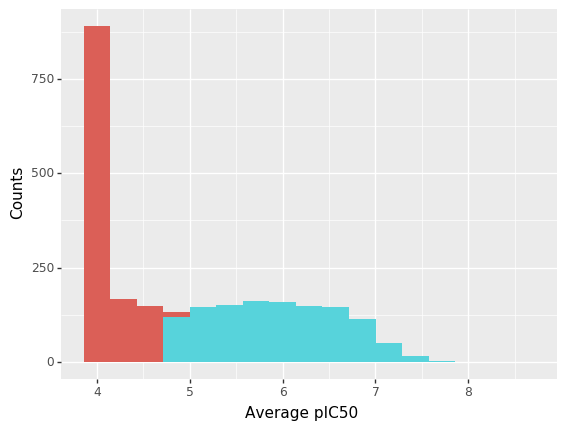

<ggplot: (8791426406897)>

In [9]:
(
    ggplot(pd.DataFrame(X, Y_raw)) +
    geom_histogram(aes(x='Y_raw', fill = (Y_raw>np.median(Y_raw)))) +
    xlab('Average pIC50') + ylab('Counts') + theme(legend_position="none")
)

## Classifier Models

### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, oob_score=True, random_state=123456)

In [11]:
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123456,
                       verbose=0, warm_start=False)

In [12]:
from sklearn.metrics import accuracy_score
rf_predicted_train = rf.predict(X_train)
rf_predicted_test = rf.predict(X_test)

train_accuracy = accuracy_score(Y_train, rf_predicted_train)
test_accuracy = accuracy_score(Y_test, rf_predicted_test)

print(f'Random Forest Classifier')
print(f'Accuracy on Training Set: {train_accuracy:.3}')
print(f'Accuracy on Test Set: {test_accuracy:.3}')

Random Forest Classifier
Accuracy on Training Set: 0.982
Accuracy on Test Set: 0.878


### MLP Classifier

In [13]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 5), random_state=1)

In [14]:
mlp.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [15]:
from sklearn.metrics import accuracy_score
mlp_predicted_train = mlp.predict(X_train)
mlp_predicted_test = mlp.predict(X_test)

train_accuracy = accuracy_score(Y_train, mlp_predicted_train)
test_accuracy = accuracy_score(Y_test, mlp_predicted_test)

print(f'MLP Classifier')
print(f'Accuracy on Training Set: {train_accuracy:.3}')
print(f'Accuracy on Test Set: {test_accuracy:.3}')

MLP Classifier
Accuracy on Training Set: 0.976
Accuracy on Test Set: 0.847


# Regressors

## Data Extraction

In [16]:
conn = sqlite3.connect("sabs_moonshot.db")
data = pd.read_sql_query("""SELECT smiles, fingerprint, r_avg_IC50, f_avg_IC50 FROM assays
    INNER JOIN compounds ON compounds.id = assays.compound_id WHERE assays.r_avg_IC50 != "" OR assays.f_avg_IC50 != "";
""", conn)

In [17]:
pd.to_numeric(data["r_avg_IC50"], errors='coerce')
pd.to_numeric(data["f_avg_IC50"], errors='coerce')
data["r_avg_IC50"] = data["r_avg_IC50"].replace("", np.NaN)
data["f_avg_IC50"] = data["f_avg_IC50"].replace("", np.NaN)
conn.close()
data = data[data["f_avg_IC50"] < 99]
data = data[data["r_avg_IC50"] < 99]
X = np.array([[int(c) for c in data["fingerprint"].iloc[i]] for i in range(len(data["fingerprint"]))])
Y = -np.log10(np.mean(data[["r_avg_IC50", "f_avg_IC50"]], axis=1).to_numpy()) + 6

In [18]:
data

,smiles,fingerprint,r_avg_IC50,f_avg_IC50
2,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,0000000000000000000000000000000000000000010000...,14.641091,26.680129
3,O=C(Cc1cncc2ccccc12)Nc1ccccc1,0000000000000000000000000000000000000000010000...,45.077469,57.469670
5,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,0000000000000000000000000000000000000000010000...,8.201698,4.222340
6,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,0000000000000000000000000000000000000000010000...,13.895165,24.566619
7,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,0000000000000000000000000000000000000000000000...,45.689263,64.413611
...,...,...,...,...
1616,Cc1ccc(C)c(S(=O)(=O)N2CCN(C(=O)CCl)CC2)c1,0000000000000000000000000000000000000000000000...,1.623369,14.216485
1637,O=C(Nc1cncc2ccccc12)C1CCOc2cc(Cl)c(Cl)cc21,0000000000000000000000000000000000000000000000...,0.309337,0.205428
1711,O=C(CCl)N1CCN(Cc2cccc(Cl)c2)CC1,0000000000000000000000000000000000000000000000...,0.545448,2.536267
1802,O=C(CCl)N1CCN(S(=O)(=O)c2cccc(F)c2)CC1,0000000000000000000000000000000000000000000000...,2.023561,3.666429


## Feature Selection
### Remove Low Variance Features

In [19]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold = 0)
X = sel.fit_transform(X)
print(f'{X.shape[1]} Features Remaining')

1322 Features Remaining


### Remove Highly Correlated Features

In [20]:
X = pd.DataFrame(X)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X.drop(to_drop, axis=1, inplace=True)
X = X.to_numpy()
print(f'{X.shape[1]} Features Remaining')

986 Features Remaining


### Split data into Test and Training Sets

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state = 123456)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (318, 986), X_test shape: (106, 986)
Y_train shape: (318,), Y_test shape: (106,)


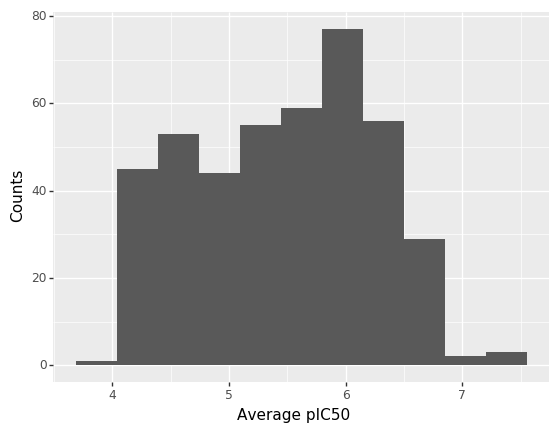

<ggplot: (8791424281717)>

In [22]:
(
    ggplot(pd.DataFrame(X, Y)) +
    geom_histogram(aes(x='Y')) +
    xlab('Average pIC50') + ylab('Counts')
)

## Regression Models

### Create Random Forest Regressor

In [23]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, oob_score=True, random_state=123456)

In [24]:
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=123456, verbose=0, warm_start=False)

In [25]:
from sklearn.metrics import max_error, mean_squared_error

rf_predicted_train = rf.predict(X_train)
rf_predicted_test = rf.predict(X_test)
train_max_error = max_error(Y_train, rf_predicted_train)
train_rms_error = mean_squared_error(Y_train, rf_predicted_train, squared=False)
test_max_error = max_error(Y_test, rf_predicted_test)
test_rms_error = mean_squared_error(Y_test, rf_predicted_test, squared=False)

print(f'Random Forest Regressor')
print(f'Training data Max Error: {train_max_error:.3}')
print(f'Train data RMS Error: {train_rms_error:.3}\n')

print(f'Test data Max Error: {test_max_error:.3}')
print(f'Test data RMS Error: {test_rms_error:.3}')

Random Forest Regressor
Training data Max Error: 1.5
Train data RMS Error: 0.281

Test data Max Error: 1.8
Test data RMS Error: 0.54


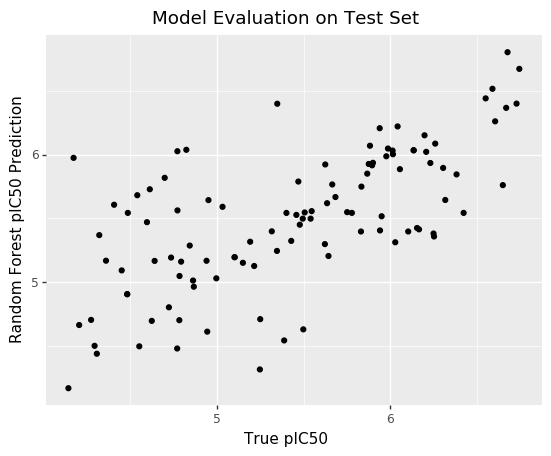

<ggplot: (8791424132653)>

In [26]:
(
    ggplot(pd.DataFrame(Y_test, rf_predicted_test)) +
    geom_point(aes(x='Y_test', y='rf_predicted_test')) +
    xlab('True pIC50') + ylab('Random Forest pIC50 Prediction') +
    ggtitle('Model Evaluation on Test Set')
)

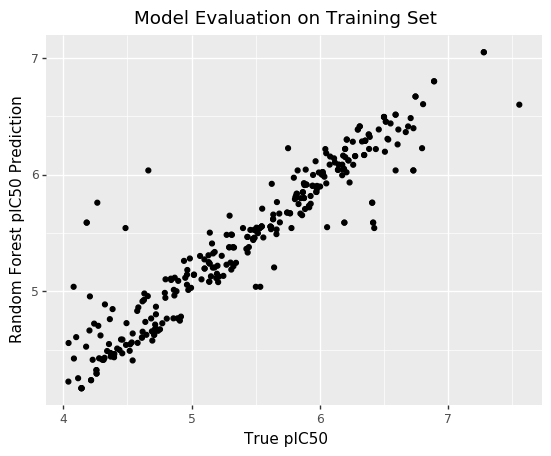

<ggplot: (8791424213741)>

In [27]:
(
    ggplot(pd.DataFrame(Y_train, rf_predicted_train)) +
    geom_point(aes(x='Y_train', y='rf_predicted_train')) +
    xlab('True pIC50') + ylab('Random Forest pIC50 Prediction') +
    ggtitle('Model Evaluation on Training Set')
)

### Create MLP Regressor

In [28]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(10, 5), random_state=1)

In [29]:
mlp.fit(X_train, Y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 5), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [30]:
from sklearn.metrics import max_error, mean_squared_error

mlp_predicted_train = mlp.predict(X_train)
mlp_predicted_test = mlp.predict(X_test)
train_max_error = max_error(Y_train, mlp_predicted_train)
train_rms_error = mean_squared_error(Y_train, mlp_predicted_train, squared=False)
test_max_error = max_error(Y_test, mlp_predicted_test)
test_rms_error = mean_squared_error(Y_test, mlp_predicted_test, squared=False)

print(f'MLP Regressor')
print(f'Training data Max Error: {train_max_error:.3}')
print(f'Train data RMS Error: {train_rms_error:.3}\n')

print(f'Test data Max Error: {test_max_error:.3}')
print(f'Test data RMS Error: {test_rms_error:.3}')

MLP Regressor
Training data Max Error: 1.42
Train data RMS Error: 0.227

Test data Max Error: 2.09
Test data RMS Error: 0.625


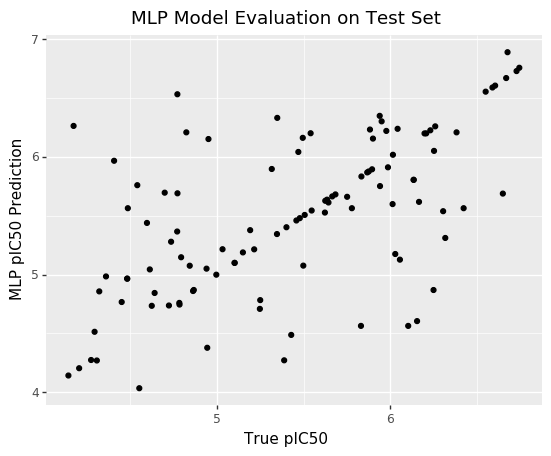

<ggplot: (8791424215069)>

In [31]:
(
    ggplot(pd.DataFrame(Y_test, mlp_predicted_test)) +
    geom_point(aes(x='Y_test', y='mlp_predicted_test')) +
    xlab('True pIC50') + ylab('MLP pIC50 Prediction') +
    ggtitle('MLP Model Evaluation on Test Set')
)

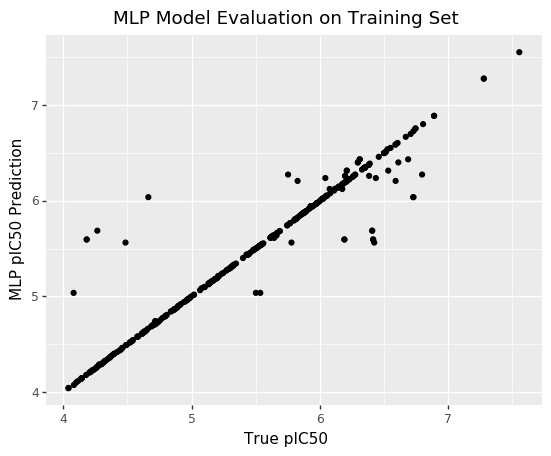

<ggplot: (8791426395573)>

In [32]:
(
    ggplot(pd.DataFrame(Y_train, mlp_predicted_train)) +
    geom_point(aes(x='Y_train', y='mlp_predicted_train')) +
    xlab('True pIC50') + ylab('MLP pIC50 Prediction') +
    ggtitle('MLP Model Evaluation on Training Set')
)

# Clustering Assayed Compounds Based on Fingerprints

### Retrieve Data

In [32]:
import sklearn.cluster
import sklearn.mixture
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import sqlite3
import pandas as pd
import numpy as np

In [33]:
conn = sqlite3.connect("sabs_moonshot.db")
data = pd.read_sql_query("""
SELECT smiles, fingerprint, r_avg_IC50, f_avg_IC50
FROM assays
INNER JOIN compounds ON compounds.id = assays.compound_id
WHERE assays.r_avg_IC50 != "" OR assays.f_avg_IC50 != "";
""", conn)
pd.to_numeric(data["r_avg_IC50"], errors='coerce')
pd.to_numeric(data["f_avg_IC50"], errors='coerce')
data["r_avg_IC50"] = data["r_avg_IC50"].replace("", np.NaN)
data["f_avg_IC50"] = data["f_avg_IC50"].replace("", np.NaN)
conn.close()
data['avg_IC50'] = np.mean(data[["r_avg_IC50", "f_avg_IC50"]], axis=1).to_numpy()
db=data

db.head()

,smiles,fingerprint,r_avg_IC50,f_avg_IC50,avg_IC50
0,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,0000000000000000000000000000000000000000000000...,NaN,54.272964,54.272964
1,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,0000000000000000000000000000000000000000000000...,NaN,63.554925,63.554925
2,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,0000000000000000000000000000000000000000010000...,14.641091,26.680129,20.660610
3,O=C(Cc1cncc2ccccc12)Nc1ccccc1,0000000000000000000000000000000000000000010000...,45.077469,57.469670,51.273569
4,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,0000000000000000000000000000000000000000000000...,NaN,99.010000,99.010000


### Generate radius-2, 2048 bits fingerprint for each compound

In [34]:
#Construct a binary fingerprint for each compound in the database
db=data
N=len(db)
fps=[]
db['fingerprint']=np.nan
for i in range(N):
    cur_smiles=db['smiles'].iloc[i]
    cur_molecule=Chem.MolFromSmiles(cur_smiles)
    cur_fps=AllChem.GetMorganFingerprintAsBitVect(cur_molecule,2,nBits=2048,useFeatures=False,useChirality=False)
    fps.append(cur_fps)
    new_str=''
    db['fingerprint'].iloc[i]=''.join([str(i) for i in np.array(cur_fps)])
db

,smiles,fingerprint,r_avg_IC50,f_avg_IC50,avg_IC50
0,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,0000000000000000000000000000000000000000000000...,NaN,54.272964,54.272964
1,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,0000000000000000000000000000000000000000000000...,NaN,63.554925,63.554925
2,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,0000000000000000000000000000000000000000010000...,14.641091,26.680129,20.660610
3,O=C(Cc1cncc2ccccc12)Nc1ccccc1,0000000000000000000000000000000000000000010000...,45.077469,57.469670,51.273569
4,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,0000000000000000000000000000000000000000000000...,NaN,99.010000,99.010000
...,...,...,...,...,...
2430,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5c...,0000000000000000000000000000000000000000010000...,NaN,7.793945,7.793945
2431,CNC(=O)CN1CC2(CCN(c3cncc4cccc(Cl)c34)C2=O)c2cc...,0000000000000000000000000000000000000000010000...,NaN,1.674005,1.674005
2432,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,0000000000000000000000000000000000000000010100...,NaN,0.682988,0.682988
2433,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,0000000000000000000000000000000000000000010000...,NaN,0.463982,0.463982


### Use UMAP to project fingerprints in a 2D Space

In [39]:
from umap import UMAP
#Store fingerprints for each components in a matrix
FPS=np.zeros((N,2048))
for i in range(len(db)):
    FPS[i,:]=np.array(fps[i])
reducer=UMAP(n_neighbors=80,n_components=2,metric='jaccard')
FPS_trans=reducer.fit_transform(FPS)

Text(0.5, 1.0, 'UMAP 2D Projection of fingerprints')

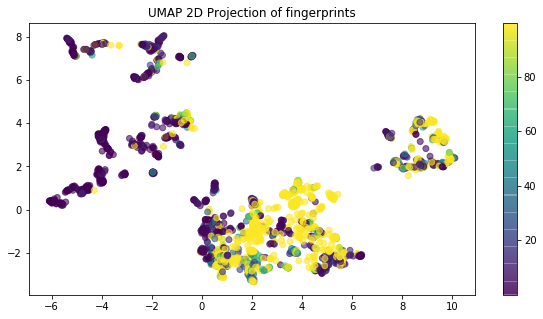

In [40]:
#Plot and overlay Avg IC50 data
avg_ic50=db['avg_IC50'].to_numpy()
fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(FPS_trans[:,0],FPS_trans[:,1],c=avg_ic50,alpha=0.6)
plt.colorbar()
plt.title('UMAP 2D Projection of fingerprints')

### Clustering with GMMs

In [41]:
#GMMs
gm=sklearn.mixture.GaussianMixture(n_components=4)
gm=gm.fit(FPS_trans)
clusters_gm=gm.predict(FPS_trans)

#K-Means
km=sklearn.cluster.KMeans(n_clusters=4)
km=km.fit(FPS_trans)
clusters_km=km.predict(FPS_trans)

Text(0.5, 1.0, 'Distribution of compounds across clusters')

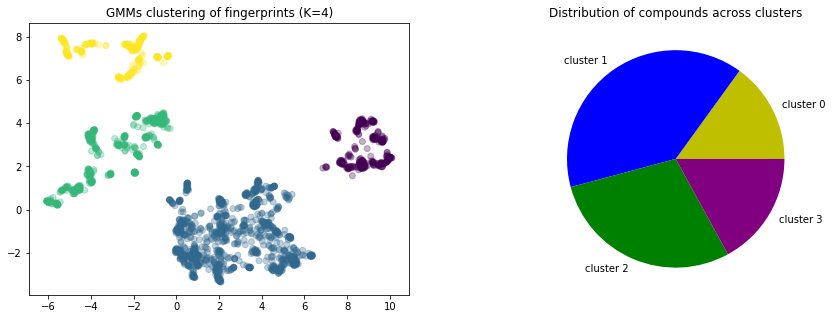

In [43]:
fig,ax=plt.subplots(1,2,figsize=(15,5))


ax[0].scatter(FPS_trans[:,0],FPS_trans[:,1],c=clusters_gm,alpha=0.3)
ax[0].set_title('GMMs clustering of fingerprints (K=4)')
cluster_sizes=[np.sum(np.where(clusters_gm==i)) for i in range(4)]
cluster_labels=['cluster '+ str(i) for i in range(4)]
ax[1].pie(cluster_sizes,labels=cluster_labels, colors=['y','b','g','purple'])
ax[1].set_title('Distribution of compounds across clusters')